<a href="https://colab.research.google.com/github/ahmer-talal/Neural-Networks/blob/main/ImageDenoising_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Load MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Normalize
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Add channel dimension
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(x_train.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28, 1)


### **Add Noise (Denoising)**

In [3]:
noise_factor = 0.4
# Add noise through numpy
x_train_noisy = x_train + noise_factor * np.random.normal(
    loc=0.0, scale=1.0, size=x_train.shape
)

x_test_noisy = x_test + noise_factor * np.random.normal(
    loc=0.0, scale=1.0, size=x_test.shape
)

# Clip values between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


### **Visualize Clean vs Noisy Images**

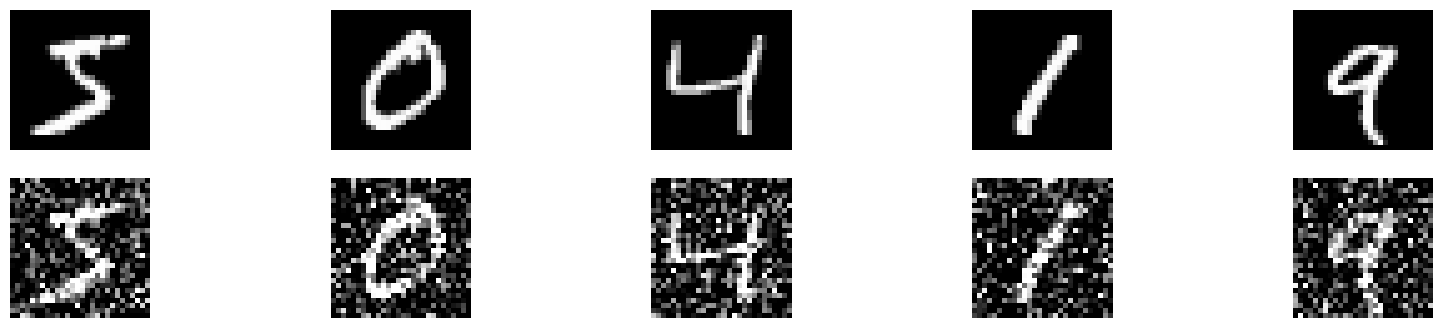

In [4]:
plt.figure(figsize=(20,4))

for i in range(5):
    # Original
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i].squeeze(), cmap="gray")
    plt.axis("off")

    # Noisy
    plt.subplot(2,5,i+6)
    plt.imshow(x_train_noisy[i].squeeze(), cmap="gray")
    plt.axis("off")

plt.show()


### **Autoencoder with Explicit Bottleneck**

In [5]:
from tensorflow.keras import layers, models

# Input
input_img = layers.Input(shape=(28, 28, 1), name="input_image")

# ---------------- Encoder ----------------
x = layers.Conv2D(32, 3, activation='relu', padding='same', name="enc_conv1")(input_img)
x = layers.MaxPooling2D(2, name="enc_pool1")(x)

x = layers.Conv2D(64, 3, activation='relu', padding='same', name="enc_conv2")(x)
x = layers.MaxPooling2D(2, name="enc_pool2")(x)

# Bottleneck (latent space)
bottleneck = layers.Conv2D(
    128, 3, activation='relu', padding='same', name="bottleneck")(x)

# ---------------- Decoder ----------------
x = layers.UpSampling2D(2, name="dec_upsample1")(bottleneck)
x = layers.Conv2D(64, 3, activation='relu', padding='same', name="dec_conv1")(x)

x = layers.UpSampling2D(2, name="dec_upsample2")(x)
x = layers.Conv2D(32, 3, activation='relu', padding='same', name="dec_conv2")(x)

output = layers.Conv2D(
    1, 3, activation='sigmoid', padding='same', name="output_image")(x)

# Autoencoder model
autoencoder = models.Model(
    inputs=input_img,
    outputs=output,
    name="Denoising_Autoencoder"
)


## **For Seperate Use:**

### **Encoder Model (Feature Extractor)**

In [7]:
encoder = models.Model(
    inputs=input_img,
    outputs=bottleneck,
    name="Encoder"
)


### **Decoder Model (Reconstructor)**

In [8]:
decoder_input = layers.Input(shape=bottleneck.shape[1:], name="decoder_input")

x = autoencoder.get_layer("dec_upsample1")(decoder_input)
x = autoencoder.get_layer("dec_conv1")(x)
x = autoencoder.get_layer("dec_upsample2")(x)
x = autoencoder.get_layer("dec_conv2")(x)
decoder_output = autoencoder.get_layer("output_image")(x)

decoder = models.Model(
    inputs=decoder_input,
    outputs=decoder_output,
    name="Decoder"
)


In [9]:
autoencoder.summary()
encoder.summary()
decoder.summary()


Model: "Denoising_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv1 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv2 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool2 (MaxPooling2D)        │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Conv2D)             │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_upsample1 (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv1 (Conv2D)              │ (None, 14, 14, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_upsample2 (UpSampling2D)    │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv2 (Conv2D)              │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_image (Conv2D)           │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,217 (723.50 KB)

 Trainable params: 185,217 (723.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv1 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv2 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool2 (MaxPooling2D)        │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Conv2D)             │ (None, 7, 7, 128)      │        73,856 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,672 (362.00 KB)

 Trainable params: 92,672 (362.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_upsample1 (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv1 (Conv2D)              │ (None, 14, 14, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_upsample2 (UpSampling2D)    │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv2 (Conv2D)              │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_image (Conv2D)           │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,545 (361.50 KB)

 Trainable params: 92,545 (361.50 KB)

 Non-trainable params: 0 (0.00 B)

### **Compile & Train**

In [11]:
autoencoder.compile(
    optimizer='adam',
    loss='binary_crossentropy'
)

autoencoder.fit(
    x_train_noisy, x_train,
    epochs=80,
    batch_size=1024,
    validation_data=(x_test_noisy, x_test),
    verbose=2
)


Epoch 1/80
59/59 - 29s - 494ms/step - loss: 0.0985 - val_loss: 0.0858
Epoch 2/80
59/59 - 5s - 84ms/step - loss: 0.0852 - val_loss: 0.0844
Epoch 3/80
59/59 - 5s - 84ms/step - loss: 0.0844 - val_loss: 0.0841
Epoch 4/80
59/59 - 5s - 84ms/step - loss: 0.0842 - val_loss: 0.0839
Epoch 5/80
59/59 - 5s - 82ms/step - loss: 0.0841 - val_loss: 0.0839
Epoch 6/80
59/59 - 5s - 81ms/step - loss: 0.0840 - val_loss: 0.0837
Epoch 7/80
59/59 - 5s - 80ms/step - loss: 0.0839 - val_loss: 0.0837
Epoch 8/80
59/59 - 5s - 80ms/step - loss: 0.0838 - val_loss: 0.0837
Epoch 9/80
59/59 - 5s - 80ms/step - loss: 0.0837 - val_loss: 0.0837
Epoch 10/80
59/59 - 5s - 81ms/step - loss: 0.0837 - val_loss: 0.0836
Epoch 11/80
59/59 - 5s - 80ms/step - loss: 0.0836 - val_loss: 0.0835
Epoch 12/80
59/59 - 5s - 79ms/step - loss: 0.0835 - val_loss: 0.0834
Epoch 13/80
59/59 - 5s - 80ms/step - loss: 0.0835 - val_loss: 0.0833
Epoch 14/80
59/59 - 5s - 80ms/step - loss: 0.0834 - val_loss: 0.0833
Epoch 15/80
59/59 - 5s - 80ms/step - loss

### **Test n Visualize Results**

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


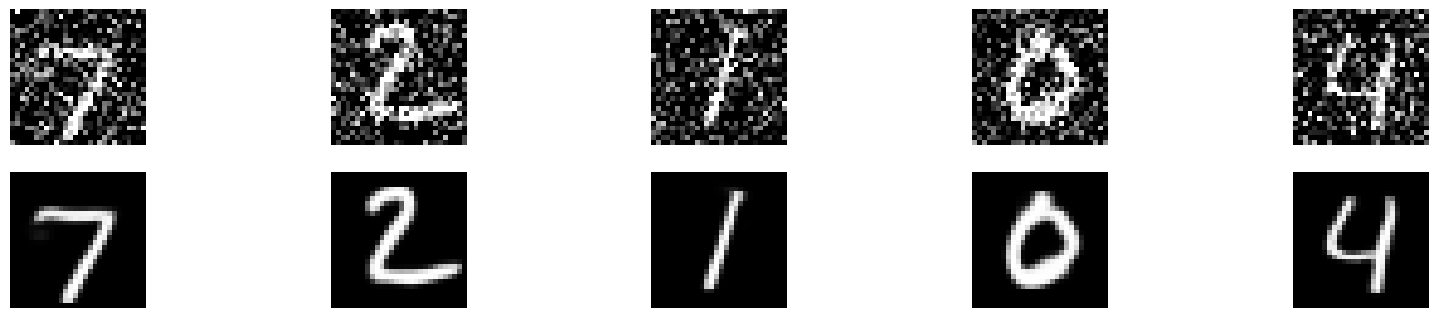

In [14]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plt.figure(figsize=(20,6))
for i in range(5):
    # Noisy
    plt.subplot(3,5,i+1)
    plt.imshow(x_test_noisy[i].squeeze(), cmap="gray")
    plt.axis("off")

    # Reconstructed
    plt.subplot(3,5,i+6)
    plt.imshow(decoded_imgs[i].squeeze(), cmap="gray")
    plt.axis("off")

    # Original
    # plt.subplot(3,5,i+11)
    # plt.imshow(x_test[i].squeeze(), cmap="gray")
    # plt.axis("off")

plt.show()


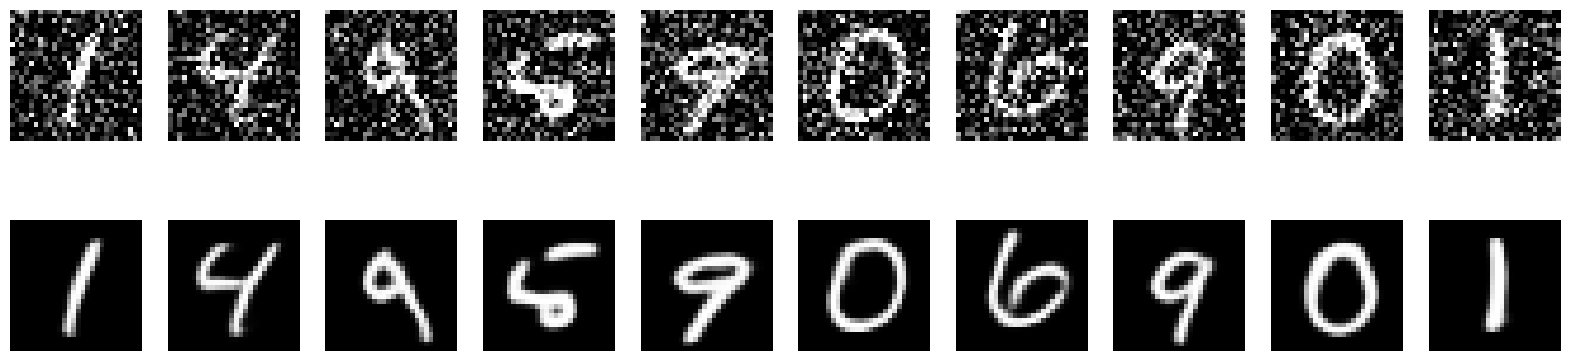

In [15]:
# Next 10 images (Index 5 to 14) testing:
plt.figure(figsize=(20, 5))

start_index = 5
num_display = 10

for i in range(num_display):
    # Dataset mein asal index (5, 6, 7... 14)
    idx = start_index + i

    # Noisy Images
    plt.subplot(2, num_display, i + 1)
    plt.imshow(x_test_noisy[idx].squeeze(), cmap="gray")
    plt.axis("off")

    # Reconstructed Images
    plt.subplot(2, num_display, i + 1 + num_display)
    plt.imshow(decoded_imgs[idx].squeeze(), cmap="gray")
    plt.axis("off")

plt.show()